<center><h1> Dealing with categorical features: Quantile Encoder </h1></center>

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import Image
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error

from category_encoders.one_hot import OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder


from sktools.selectors import TypeSelector
from sktools.encoders import QuantileEncoder
%matplotlib inline
plt.style.use('seaborn')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

warnings.filterwarnings('ignore')


Read the data, select some columns and fill nan

In [4]:
df = pd.read_csv('stackoverflow.csv',low_memory=False)

df = df[["Country", "Employment", "FormalEducation", "DevType", "LanguageWorkedWith","ConvertedSalary"]].fillna(0)

df.columns = ['Country', 'Employment', 'FormalEducation', 'DevType',
       'LanguageWorkedWith', 'AnnualSalary']

In [5]:
df.head()

,Country,Employment,FormalEducation,DevType,LanguageWorkedWith,AnnualSalary
0,United Kingdom,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Database administrator;DevOps specialist;Full-...,JavaScript;Python;Bash/Shell,70841.0
1,South Africa,Employed full-time,Some college/university study without earning ...,Data or business analyst;Desktop or enterprise...,C;C++;Java;Matlab;R;SQL;Bash/Shell,21426.0
2,United Kingdom,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Back-end developer;Database administrator;Fron...,Java;JavaScript;Python;TypeScript;HTML;CSS,41671.0
3,United States,Employed full-time,Some college/university study without earning ...,Back-end developer;Front-end developer;Full-st...,JavaScript;HTML;CSS,120000.0
4,United States,Employed full-time,Some college/university study without earning ...,"Back-end developer;C-suite executive (CEO, CTO...",Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...,250000.0


## Overview of the dataset

#### Employment

Employment type:  7


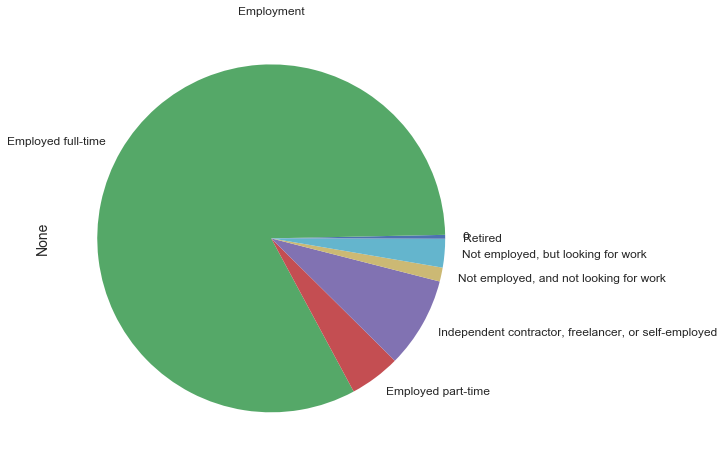

In [6]:
plt.figure()
print('Employment type: ',df.Employment.nunique())
plt.title('Employment')
df.groupby('Employment').size().plot.pie();
plt.show();

#### FormalEducation

Types of different education:  10


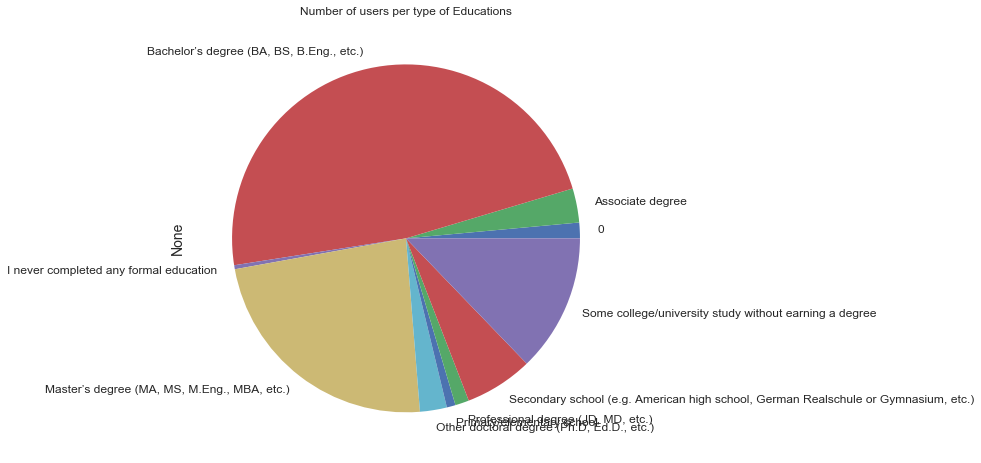

In [7]:
print('Types of different education: ',df.FormalEducation.nunique())
plt.figure()
plt.title('Number of users per type of Educations')
df.groupby('FormalEducation').size().plot.pie();
plt.show();

#### Country

Total number of countries:  157


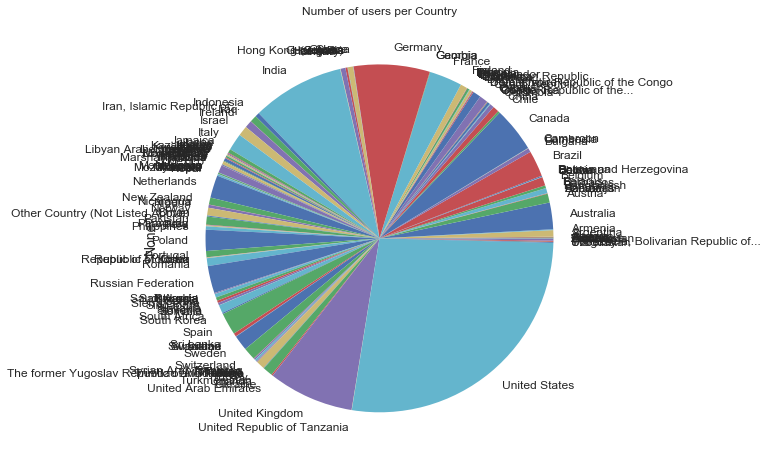

In [8]:
plt.figure()
print('Total number of countries: ',df.Country.nunique())
plt.title('Number of users per Country')
df.groupby('Country').size().plot.pie();
plt.show();

#### Categorical Features

In [9]:
print("Country: ", df.Country.nunique())
print("Employment: ", df.Employment.nunique())
print("Formal Education: ", df.FormalEducation.nunique())
print("Dev Type: ", df.DevType.nunique())
print("Language worked with: ", df.LanguageWorkedWith.nunique())

Country:  157
Employment:  7
Formal Education:  10
Dev Type:  6161
Language worked with:  17788


## Label/Target

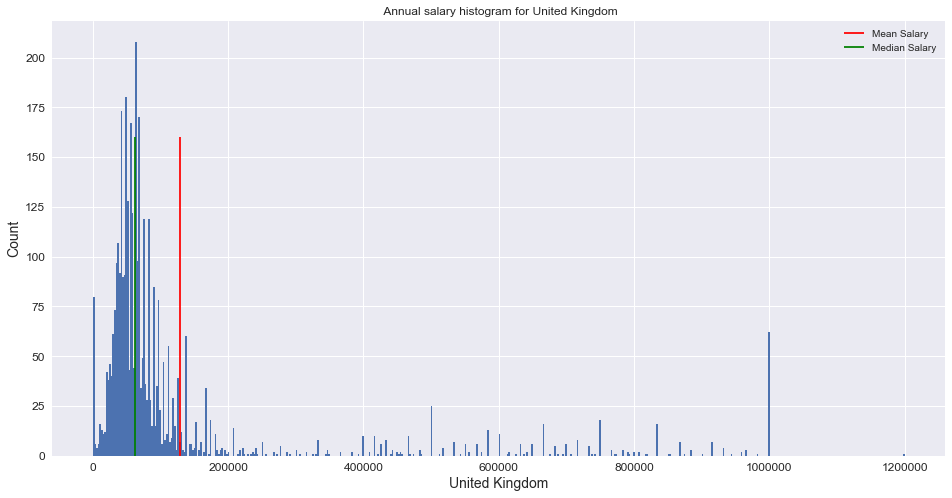

In [10]:
aux = df[df["Country"] == "United Kingdom"]
plt.figure()
plt.title(" Annual salary histogram for United Kingdom")
plt.vlines(x=aux.AnnualSalary.mean(), ymin=0, ymax=160, label="Mean Salary", colors="r")
plt.vlines(
    x=aux.AnnualSalary.median(), ymin=0, ymax=160, label="Median Salary", colors="g"
)
plt.ylabel("Count")
plt.legend()
plt.xlabel("United Kingdom")
aux.AnnualSalary.hist(bins=500)
plt.show()

In [11]:
df[(df['AnnualSalary']>1_750_000) & (df['Country']=='Turkey')]

,Country,Employment,FormalEducation,DevType,LanguageWorkedWith,AnnualSalary
34465,Turkey,Employed part-time,"Professional degree (JD, MD, etc.)",Front-end developer;Full-stack developer;Game ...,C;C++;C#;CoffeeScript;JavaScript;Perl;PHP;Pyth...,2000000.0


## Dataset insights

 - **High Cardinality Categorical Data** A lot of categories per feature.
 - **Regression Target**  (Salary)
 - **Outliers or errors** in the data (real data)

## Machine Learning
A pipeline containing:
 - **Train/Test Split**: Random train test split with 0.75% of the data used for train
 - **Encoder**: Diferent encoding techniques to deal with cateogrical data.
 - **Model**: Elastic Net (Generalized Linear Models)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns="AnnualSalary"), df.AnnualSalary, random_state=0
)

### One hot encoding



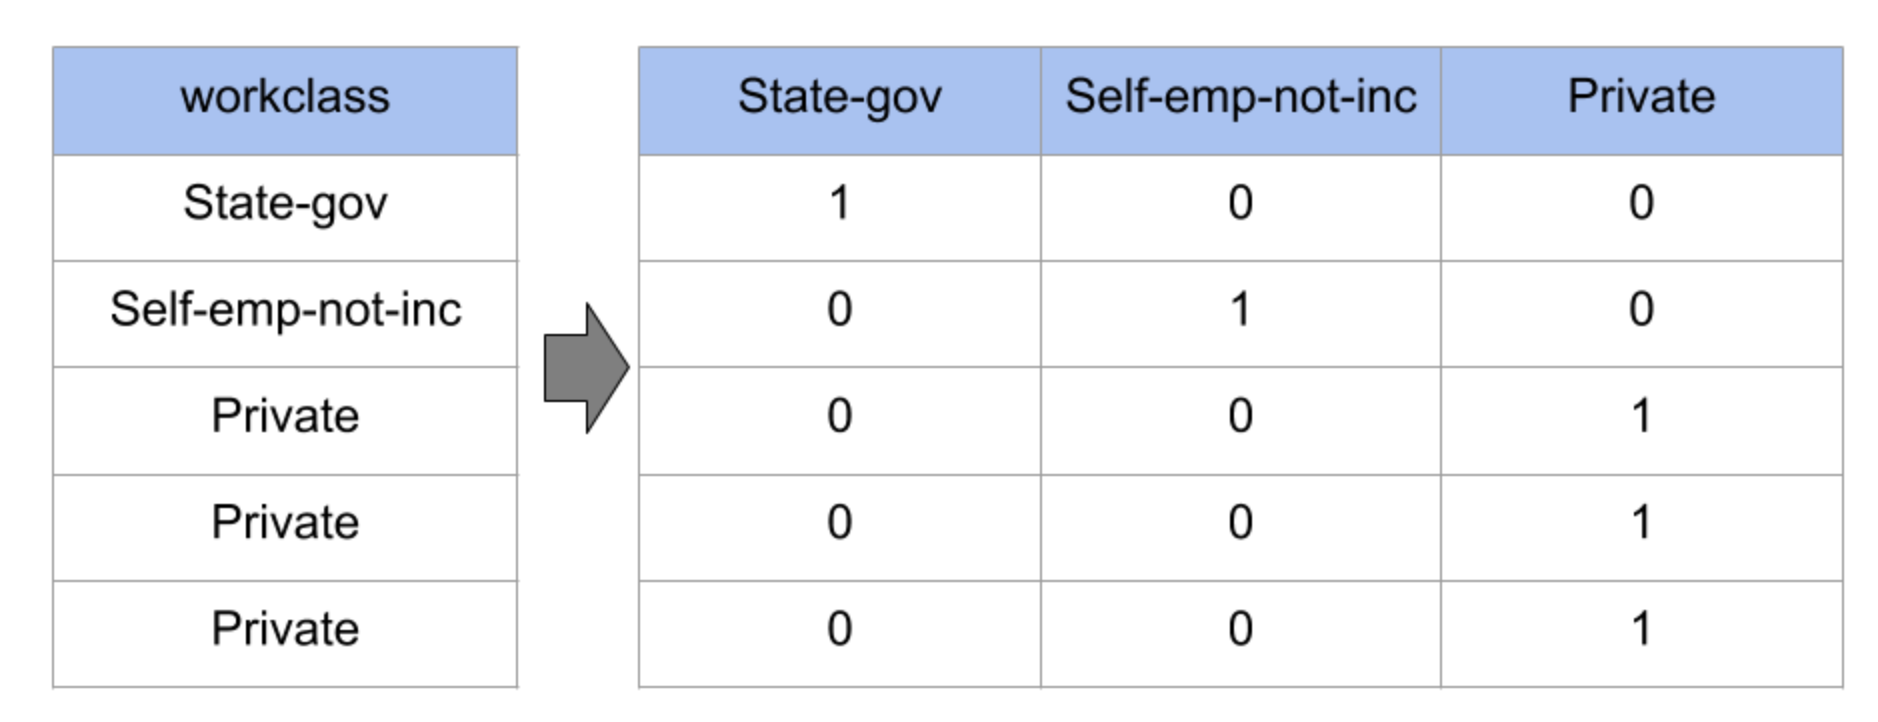

In [13]:
Image("one_hot.png")

In [14]:
# Steps of the pipeline
one_hot = OneHotEncoder(cols=["Country", "FormalEducation"], use_cat_names=True)
enet = ElasticNet()


# Pipeline
pipe_ohe = Pipeline(
    [("one_hot", one_hot),
     ("type", TypeSelector(np.number)),
     ("enet", enet)]
)

In [15]:
pipe_ohe.fit(X_train,y_train);

In [16]:
print(Pipeline(pipe_ohe.steps[:-1]).transform(X_train).shape)
Pipeline(pipe_ohe.steps[:-1]).transform(X_train).head()

(35776, 163)


,Country_Germany,Country_United States,Country_Greece,Country_Canada,Country_United Kingdom,Country_India,Country_Japan,Country_Romania,Country_France,Country_Spain,Country_Poland,Country_Russian Federation,Country_Austria,Country_Netherlands,Country_Italy,Country_Israel,Country_Singapore,Country_Pakistan,Country_Brazil,Country_Switzerland,Country_Lithuania,Country_New Zealand,Country_Ukraine,Country_Malaysia,Country_Australia,Country_China,Country_Ireland,Country_Cyprus,Country_Sri Lanka,Country_Belgium,Country_Chile,Country_Bangladesh,"Country_Iran, Islamic Republic of...",Country_Turkey,Country_Norway,Country_Denmark,Country_Czech Republic,Country_Belarus,Country_South Africa,Country_Serbia,Country_Ghana,Country_Jordan,Country_Nigeria,Country_Indonesia,Country_Sweden,Country_Portugal,Country_Mexico,Country_Finland,Country_Slovenia,Country_Viet Nam,Country_Kazakhstan,Country_Zimbabwe,Country_Other Country (Not Listed Above),Country_Croatia,Country_Estonia,Country_Hungary,Country_Argentina,Country_Madagascar,Country_Hong Kong (S.A.R.),Country_Slovakia,Country_Thailand,Country_Colombia,Country_Bahamas,Country_Bulgaria,Country_Dominican Republic,Country_Azerbaijan,Country_Saudi Arabia,Country_Morocco,Country_Uzbekistan,Country_Algeria,Country_Egypt,Country_Guatemala,Country_Rwanda,Country_Nepal,Country_Sudan,Country_Kenya,Country_Peru,Country_Bosnia and Herzegovina,Country_Armenia,Country_Ethiopia,Country_Liechtenstein,Country_Philippines,Country_Oman,Country_Uruguay,Country_Lebanon,Country_Tunisia,Country_Malta,Country_Maldives,Country_United Arab Emirates,Country_Cameroon,"Country_Venezuela, Bolivarian Republic of...",Country_Iraq,Country_South Korea,Country_Albania,Country_Somalia,Country_Paraguay,Country_Syrian Arab Republic,Country_Afghanistan,Country_Mongolia,Country_Uganda,Country_Latvia,Country_Bolivia,Country_Luxembourg,Country_Republic of Korea,Country_Georgia,Country_Taiwan,Country_Trinidad and Tobago,Country_Cambodia,Country_Costa Rica,Country_The former Yugoslav Republic of Macedonia,Country_Andorra,Country_Panama,Country_Zambia,Country_Yemen,Country_Tajikistan,Country_Cuba,Country_Bahrain,Country_El Salvador,Country_Kyrgyzstan,Country_Ecuador,Country_Republic of Moldova,Country_Iceland,Country_Qatar,Country_Barbados,Country_Fiji,Country_Nicaragua,Country_Mozambique,Country_Kuwait,Country_Jamaica,Country_United Republic of Tanzania,Country_Myanmar,Country_Libyan Arab Jamahiriya,Country_Montenegro,Country_Suriname,Country_Mauritius,Country_Saint Lucia,"Country_Congo, Republic of the...",Country_Senegal,Country_Guyana,Country_Bhutan,Country_Eritrea,Country_Honduras,Country_Dominica,Country_Benin,Country_Namibia,Country_Democratic Republic of the Congo,Country_Swaziland,Country_Botswana,Country_Lesotho,Country_Togo,Country_Malawi,Country_Monaco,Country_Turkmenistan,"FormalEducation_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",FormalEducation_Associate degree,FormalEducation_0,"FormalEducation_Master’s degree (MA, MS, M.Eng., MBA, etc.)","FormalEducation_Bachelor’s degree (BA, BS, B.Eng., etc.)",FormalEducation_Some college/university study without earning a degree,"FormalEducation_Professional degree (JD, MD, etc.)","FormalEducation_Other doctoral degree (Ph.D, Ed.D., etc.)",FormalEducation_Primary/elementary school,FormalEducation_I never completed any formal education
10760,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
39072,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### One Hot Encoding problems
 1. The **input data** for the model **becomes very wide**, and neither an optimal nor an efficient approach are guaranteed, 

 2. The created **features become sparse**(most of the levels hardly appear in the data) 

 3. One Hot Encoding does not handle new and **unseen categories**

## Target Encoding

In target encoding, categorical features are replaced with the mean tar-get value of each respective category.  With this technique,the high cardinality problem is handled and categories are ordered allowing for easy extraction of the information and model simplification. The main drawback of Target Encoding is overfitting.  

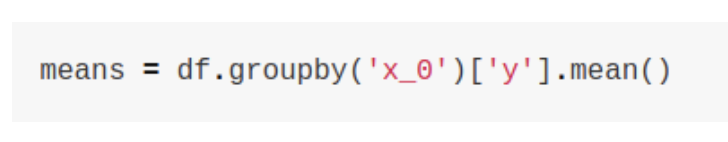

In [17]:
Image('te_code.png')

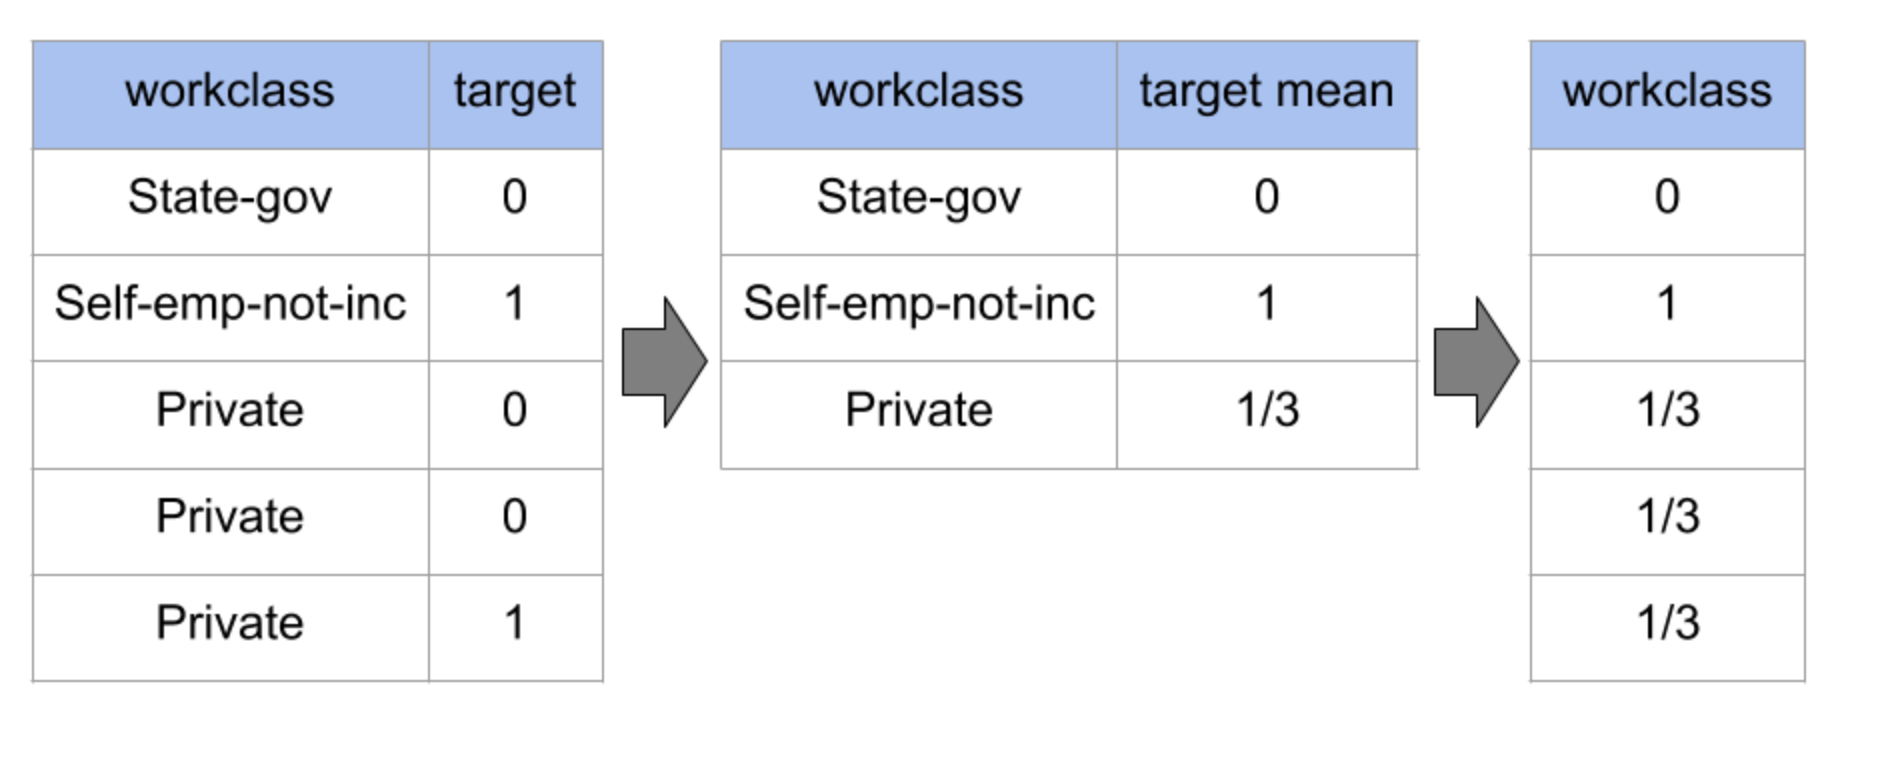

In [21]:
Image('te.png')

In [22]:
target_encoder = MEstimateEncoder()
enet = ElasticNet()


In [23]:
pipe_te = Pipeline(
    [("target", target_encoder), ("type", TypeSelector(np.number)), ("enet", enet)]
)

In [24]:
pipe_te.fit(X_train,y_train);


In [25]:
Pipeline(pipe_te.steps[:-1]).transform(X_train).head()

,Country,Employment,FormalEducation,DevType,LanguageWorkedWith
10760,91844.906214,100706.410749,67868.995623,64927.437875,80787.613025
39072,154110.394690,100706.410749,101870.898904,75351.691058,94723.516282
18594,154110.394690,100706.410749,87868.278107,99422.924335,85130.266282
26569,44081.086086,100706.410749,100848.604006,64159.654791,54553.032564
28743,98255.587029,100706.410749,96690.407186,100099.475500,95027.588761


### Target Encoding 
 - Benefits

     - **High cardinality** problem is handled 
     - **Categories are ordered** allowing for easy extraction of the information and model simplification
 - Drawbacks
     - Overfitting
     - Using the **mean is not be the best aggregation statistics** for all cases. More when we have outliers on the data.
     
 
 

<center><h1> Our proposal: </h1><h2> Quantile Encoder</h2></center>


Our proposed encoding consists of using a different encoding function than the mean. The mean is just a particular statistic,and we can give richer and more meaningful encodings by using  other  aggregation  functions.   For  this  work,  we  use quantiles as an alternative way to aggregate the target in the different categories.

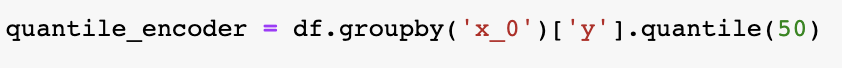

In [26]:
Image('qe_code.png')

In [27]:
quantile_encoder = QuantileEncoder()
enet = ElasticNet()


In [28]:
pipe_qe = Pipeline(
    [("quantile", quantile_encoder), ("type", TypeSelector(np.number)), ("enet", enet)]
)

In [29]:
pipe_qe.fit(X_train,y_train);


In [30]:
Pipeline(pipe_qe.steps[:-1]).transform(X_train).head()

,Country,Employment,FormalEducation,DevType,LanguageWorkedWith
10760,61191.734923,59969.846871,30607.947357,51719.785714,65287.900000
39072,99995.426760,59969.846871,54169.135315,66147.640845,91111.875000
18594,99995.426760,59969.846871,36942.588619,55000.434466,68936.625000
26569,24042.488571,59969.846871,59969.461863,39865.510471,34329.750000
28743,64411.044157,59969.846871,58751.806732,61191.726859,52287.291667


# Evaluate encoders

The metric we will be using is the Mean Absolute Error
<center><h2> $MAE = \frac{1}{n}  \sum_{j=1}^M |\hat{y}_j - y_j|$</h2></center>

In [31]:
print('MAE in test set for One Hot Encoding: ', mean_absolute_error(pipe_ohe.predict(X_test),y_test))
print('MAE in test set for Target Encoding: ', mean_absolute_error(pipe_te.predict(X_test),y_test))
print('MAE in test set for Quantile Encoding: ', mean_absolute_error(pipe_qe.predict(X_test),y_test))


MAE in test set for One Hot Encoding:  79944.0128587011
MAE in test set for Target Encoding:  87416.04154045637
MAE in test set for Quantile Encoding:  74615.49379223454


In [32]:
encoders = ["One Hot", "Target Enc", "Quantile Enc"]
error = [
    mean_absolute_error(pipe_ohe.predict(X_test), y_test),
    mean_absolute_error(pipe_te.predict(X_test), y_test),
    mean_absolute_error(pipe_qe.predict(X_test), y_test),
]

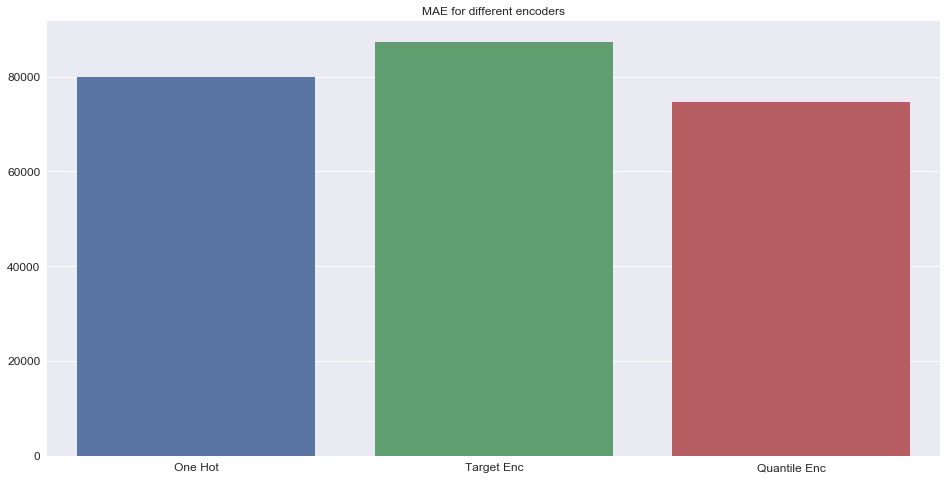

In [33]:
plt.figure()
plt.title('MAE for different encoders')
sns.barplot(x=encoders,y=error)
plt.show()

# Conclussions

### Paper Contributions

Three contributions:
 - **Quantile Encoder** 

 -  **Not all encodings are optimal for all metrics or loss functions**

 - **Set of quantiles features**
 


### Presentations takeaways

 - How to deal with categorical features in supervised learning
 - Machine Learning pipeline example
 - Category encoders and sktools python libraries.

## MCA

In [29]:
import prince


In [30]:
mca = prince.MCA(
    n_components=20,
    n_iter=3,
    copy=True,
    check_input=True,
    engine="auto",
    random_state=42,

)
enet = ElasticNet()

In [31]:
pipe_mca = Pipeline(
    [("mca", mca), ("type", TypeSelector(np.number)), ("enet", enet)]
)

In [32]:
pipe_mca.fit(X_train[["Country", "FormalEducation"]],y_train);


In [33]:
Pipeline(pipe_mca.steps[:-1]).transform(X_train[["Country", "FormalEducation"]]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
10760,1.347673,1.339512,-0.067774,0.971820,0.237302,0.333760,-0.306870,-0.138963,-0.386329,-0.035081,0.035439,-0.381460,0.041362,0.181928,-0.360817,0.184965,0.130074,0.160525,0.151719,0.233837
39072,-0.498825,0.162588,-0.869585,-0.655442,1.736855,0.245114,-0.558799,0.107549,0.145931,-0.058912,-0.037575,0.081973,-0.066666,0.106844,-0.180709,-0.098109,-0.083663,-0.039794,0.078577,0.095596
18594,0.131738,0.254048,0.756418,0.920287,0.939167,0.025416,1.353585,0.809554,0.945633,-0.058912,-0.037575,0.081973,-0.066666,0.106844,-0.180709,-0.098109,-0.083663,-0.039794,0.078577,0.095596
26569,1.185039,0.091111,-0.326973,0.054494,-0.610455,-0.008422,-0.801117,-0.636602,0.301306,-0.489257,-1.034032,-1.299776,-0.993724,0.869183,0.391779,-0.135641,-0.184234,-1.240010,-2.373381,0.235767
28743,-0.648346,-0.164959,0.140674,0.213266,0.510982,-0.225987,0.008931,0.165831,0.426648,-0.212719,-0.162514,-0.184465,0.039125,-0.013324,0.572174,-0.059813,-0.016061,-0.041522,0.239879,-0.016658


In [34]:
print(
    "MAE in train set for MCA: ",
    mean_absolute_error(pipe_mca.predict(X_train[["Country", "FormalEducation"]]), y_train)
)

MAE in train set for MCA:  80408.34551843135


In [35]:
print(
    "MAE in test set for MCA: ",
    mean_absolute_error(pipe_mca.predict(X_test[["Country", "FormalEducation"]]), y_test)
)

ValueError: dimension mismatch

In [ ]:
import prince


mca = prince.MCA(
    n_components=20,
    n_iter=3,
    copy=True,
    check_input=True,
    engine="auto",
    random_state=42,

)
enet = ElasticNet()

pipe_mca = Pipeline(
    [("mca", mca), ("type", TypeSelector(np.number)), ("enet", enet)]
)

pipe_mca.fit(X_train[["Country", "FormalEducation"]],y_train);


Pipeline(pipe_mca.steps[:-1]).transform(X_train[["Country", "FormalEducation"]]).head()

print(
    "MAE in train set for MCA: ",
    mean_absolute_error(pipe_mca.predict(X_train[["Country", "FormalEducation"]]), y_train)
)

print(
    "MAE in test set for MCA: ",
    mean_absolute_error(pipe_mca.predict(X_test[["Country", "FormalEducation"]]), y_test)
)

